# PESTPP-GLM Part 2

In this notebook, we will actually run PESTPP-GLM in standard parameter estimation mode and regularization mode.  In both cases, we will use the baked-in bayes-linear posterior monte carlo analysis to get posterior forecast PDFs.  We will use the prior monte carlo outputs as the prior forecast PDF. We will reuse the jacobian we used for FOSM to save runs

In [1]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size']=12
import flopy
import pyemu


flopy is installed in /Users/jwhite/Dev/mf6flopy2019_Neuchatel/notebooks/dauq/flopy


## SUPER IMPORTANT: SET HOW MANY PARALLEL WORKERS TO USE

In [2]:
num_workers = 20

In [3]:
t_d = "template"
m_d = "master_glm_run"

In [4]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg_pp.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
cn_hk6,cn_hk6,log,1,0,1,-1,0.5
cn_hk7,cn_hk7,log,1,0,1,-1,0.5
cn_hk8,cn_hk8,log,1,0,1,-1,0.5
cn_rech4,cn_rech4,log,1,0,1,-1,0.5
cn_rech5,cn_rech5,log,1,0,1,-1,0.5
cn_ss6,cn_ss6,log,1,0,1,-1,0.5
cn_ss7,cn_ss7,log,1,0,1,-1,0.5
cn_ss8,cn_ss8,log,1,0,1,-1,0.5
cn_strt6,cn_strt6,log,1,0,0.0211893,-0.0222764,0.0108664
cn_strt7,cn_strt7,log,1,0,0.0211893,-0.0222764,0.0108664


Load and extract the portion of the prior we need for FOSM

In [5]:
cov = pyemu.Cov.from_binary(os.path.join(t_d,"prior_cov.jcb"))
cov.get(pst.adj_par_names).to_ascii(os.path.join(t_d,"glm_prior.cov"))

 set some control options

In [6]:
pst.control_data.noptmax = 3
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 3
pst.pestpp_options["glm_num_reals"] = 50 # this is how many ies uses
pst.pestpp_options["parcov"] = "glm_prior.cov"
pst.pestpp_options["base_jacobian"] = "freyberg_reuse.jcb"
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

noptmax:3, npar_adj:428, nnz_obs:15


In [7]:
shutil.copy2(os.path.join("master_glm","freyberg_pp.jcb"),
             os.path.join(t_d,"freyberg_reuse.jcb"))

'template/freyberg_reuse.jcb'

In [8]:
pyemu.os_utils.start_workers(t_d,"pestpp-glm","freyberg_pp.pst",num_workers=num_workers,worker_root=".",
                           master_dir=m_d)

In [9]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

/Users/jwhite/Dev/mf6flopy2019_Neuchatel/notebooks/dauq/pyemu/en.py:365: UserWarning: Ensemble.from_dataframe() is deprecated and has been replaced with the standard constructor, which takesthe same arguments
  warnings.warn("Ensemble.from_dataframe() is deprecated and has been "


real_name
48     913.287391
39     937.652537
38     994.647781
19     998.379455
44    1021.377571
25    1053.232733
11    1059.289055
45    1067.912239
8     1080.682671
23    1081.802862
4     1135.986465
22    1252.639440
42    1484.288028
1     1593.845822
18    1621.260472
7     1638.329701
13    1792.308921
41    1833.227592
9     1845.852821
29    2076.183630
dtype: float64

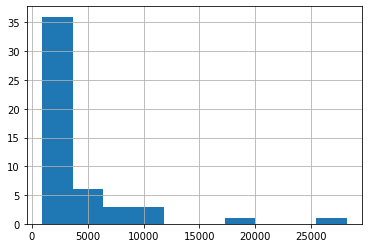

In [10]:
ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))
oe.phi_vector.sort_values().iloc[:20]

Here we see the distribution of phi values across the 100 posterior realizations.  Should we accept all of these???  The theoretical phi for each realization that we should accept is number of nonzero obs (14).

To get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [11]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] #just take the 20 lowest phi realizations

We can also load and plot the FOSM forecast results along side of the ensemble results:

In [12]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_19791230,-977.2390,1050.85000,-3078.9300,1124.4500,-3355.1400,304.988000,-3965.1100,-2745.1600
fa_hw_19801229,-500.5320,855.25200,-2211.0400,1209.9700,-739.0600,709.745000,-2158.5500,680.4300
fa_tw_19791230,-453.0330,917.67400,-2288.3800,1382.3200,-2644.8200,169.417000,-2983.6500,-2305.9800
fa_tw_19801229,-11.2061,797.59100,-1606.3900,1583.9800,1094.9400,638.585000,-182.2340,2372.1100
hds_00_013_002_000,39.6102,4.49166,30.6269,48.5936,38.5697,0.299358,37.9710,39.1684
hds_00_013_002_001,39.0079,3.90166,31.2046,46.8113,35.3969,1.322820,32.7513,38.0426


//miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


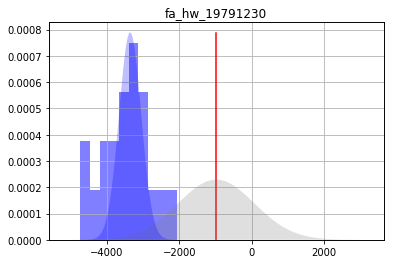

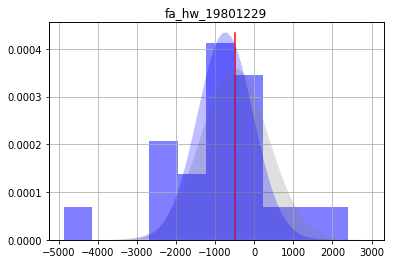

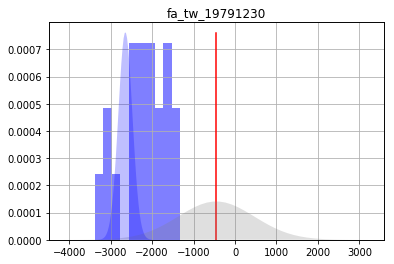

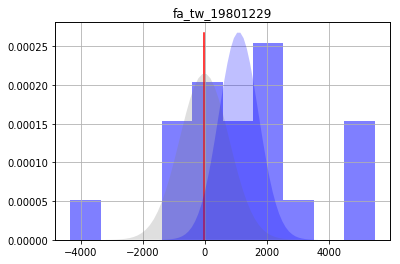

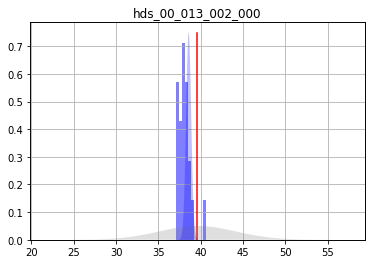

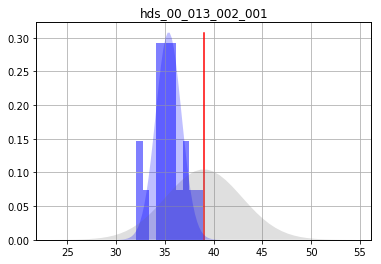

In [13]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,normed=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()

### Check your understanding:  
What assumption did the posterior FOSM Monte Carlo relax? 

### Check your understanding:  
Why didn't the posterior parameter realizations yield a lower phi?  What are the implications of accepting realizations with a higher phi?

### Setup of Tikhonov regularization

Now lets setup and use some formal regularization to bring the final phi up to around 14.  We will use first-order regularization based on the covariance matrix we build earlier:

In [14]:
cov = pyemu.Cov.from_ascii(os.path.join(t_d,"glm_prior.cov"))

In [15]:
pyemu.helpers.first_order_pearson_tikhonov(pst,cov)

getting CC matrix
processing


In [16]:
pst.prior_information.sort_values(by="weight",ascending=False).iloc[-10:]

,pilbl,equation,obgnme,weight
pilbl,,,,
pcc_1956,pcc_1956,1.0 * log(ss003) - 1.0 * log(ss021) = 0.0,regul_cc,0.001221
pcc_704,pcc_704,1.0 * log(hk108) - 1.0 * log(hk131) = 0.0,regul_cc,0.001221
pcc_159,pcc_159,1.0 * log(hk004) - 1.0 * log(hk028) = 0.0,regul_cc,0.001221
pcc_132,pcc_132,1.0 * log(hk003) - 1.0 * log(hk021) = 0.0,regul_cc,0.001221
pcc_248,pcc_248,1.0 * log(hk008) - 1.0 * log(hk031) = 0.0,regul_cc,0.001221
pcc_1500,pcc_1500,1.0 * log(rech003) - 1.0 * log(rech021) = 0.0,regul_cc,0.001221
pcc_1590,pcc_1590,1.0 * log(rech007) - 1.0 * log(rech025) = 0.0,regul_cc,0.001221
pcc_1616,pcc_1616,1.0 * log(rech008) - 1.0 * log(rech031) = 0.0,regul_cc,0.001221
pcc_1527,pcc_1527,1.0 * log(rech004) - 1.0 * log(rech028) = 0.0,regul_cc,0.001221


In [17]:
pst.reg_data.phimlim = pst.nnz_obs
pst.reg_data.phimaccept = pst.reg_data.phimlim * 1.1
pst.pestpp_options["glm_num_reals"] = 50
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

noptmax:3, npar_adj:428, nnz_obs:15


In [18]:
pyemu.os_utils.start_workers(t_d,"pestpp-glm","freyberg_pp.pst",num_workers=num_workers,worker_root=".",
                           master_dir=m_d)

In [19]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

real_name
48     913.287391
39     937.652537
38     994.647781
19     998.379455
44    1021.377571
25    1053.232733
11    1059.289055
45    1067.912239
8     1080.682671
23    1081.802862
4     1135.986465
22    1252.639440
42    1484.288028
1     1593.845822
18    1621.260472
7     1638.329701
13    1792.308921
41    1833.227592
9     1845.852821
29    2076.183630
dtype: float64

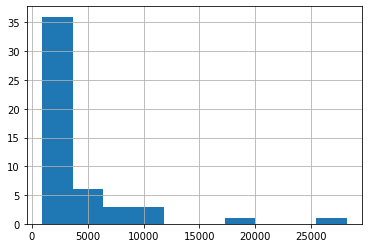

In [20]:
ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))
oe.phi_vector.sort_values().iloc[:20]

Same as before, to get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [21]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] 

In [22]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_19791230,-977.2390,1050.85000,-3078.9300,1124.4500,-3355.1400,304.988000,-3965.1100,-2745.1600
fa_hw_19801229,-500.5320,855.25200,-2211.0400,1209.9700,-739.0600,709.745000,-2158.5500,680.4300
fa_tw_19791230,-453.0330,917.67400,-2288.3800,1382.3200,-2644.8200,169.417000,-2983.6500,-2305.9800
fa_tw_19801229,-11.2061,797.59100,-1606.3900,1583.9800,1094.9400,638.585000,-182.2340,2372.1100
hds_00_013_002_000,39.6102,4.49166,30.6269,48.5936,38.5697,0.299358,37.9710,39.1684
hds_00_013_002_001,39.0079,3.90166,31.2046,46.8113,35.3969,1.322820,32.7513,38.0426


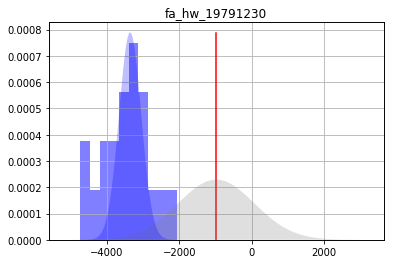

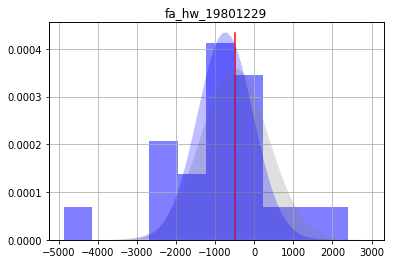

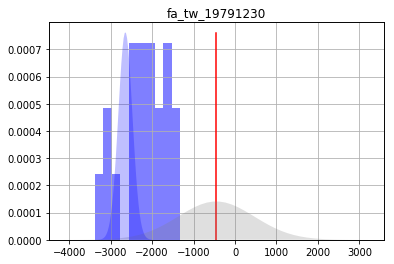

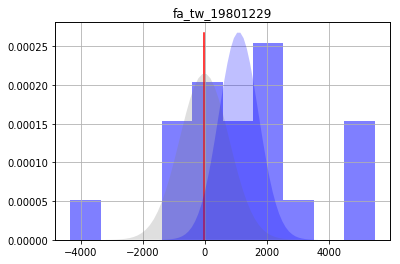

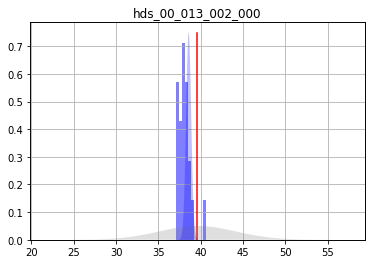

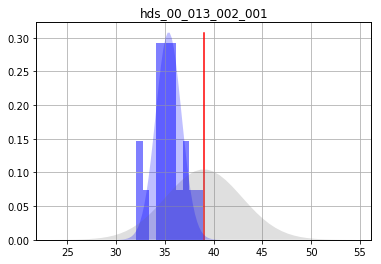

In [23]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,normed=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()